In [23]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Speeding up the solution of PDEs
#### Tan Beng Hau, Cavitation Lab

In this notebook I have written some notes on how to speed up the numerical solution of the Laplace equation. Although Python is pretty and elegant, it is rather slow. One obvious way to speed it up is to integrate it with C. You can do it indirectly, using the C-optimised `numpy` slices, and `numpy` does all the backend work for you. In `weave` you have to write pure C code. I'll also do the same thing in `numba`, which is by far my favourite. There's also another package, `cython`, which [translates your Python code into C](http://nbviewer.ipython.org/gist/anonymous/4271861), but it is not self-contained in an iPython notebook (you have to create a few other files, but it's not as difficult as it sounds) so I don't show it here. 

The **executive summary** is that you can already get a rather dramatic speed boost (40$\times$, and even greater when the calculations are cached) simply by writing the code as an array slice in `numpy`. Using the `numba` package is the simplest way to optimise the speed of the code.

## Numerical solution of the Laplace equation

The Laplace equation is

$$ \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} = 0.$$

In discretised form,

$$ \frac{\partial^2 u}{\partial x^2} = \frac{u_{i-1,j} - 2u_{i,j} + u_{i+1,j}}{2 (\Delta x)^2}, $$

and 

$$ \frac{\partial^2 u}{\partial y^2} = \frac{u_{i,j-1} - 2u_{i,j} + u_{i,j+1}}{2 (\Delta y)^2}. $$

Combining the two equations gives

$$ (\Delta y)^2 (u_{i-1,j} - 2u_{i,j} + u_{i+1,j}) + (\Delta x)^2 (u_{i,j-1} - 2u_{i,j} + u_{i,j+1}) = 0. $$

Simplifying gives 

$$ 2(\Delta x^2 + \Delta y^2) u_{i,j} = (u_{i-1,j} + u_{i+1,j})\Delta y^2 + (u_{i,j-1} + u_{i,j+1})\Delta x^2. $$

We therefore write the discretisation equation

$$ u_{i,j} = \frac{(u_{i-1,j} + u_{i+1,j})\Delta y^2 + (u_{i,j-1} + u_{i,j+1})\Delta x^2}{2(\Delta x^2) + 2(\Delta y^2)}. $$

### Pure Python code

In [24]:
def py_update(u, dx2 ,dy2):
    """ Update the u vector at every time step. """
    nx, ny = u.shape
    for i in range(1, nx-1):
        for j in range(1,ny-1):
            u[i,j] = ((u[i-1,j] + u[i+1,j])*dy2 + (u[i,j-1] + u[i,j+1])*dx2 )/(2*dy2 + 2*dx2)

In [17]:
def calc(dx,dy,n, function, nSteps):
    u = zeros((n,n))
    
    for i in range(nSteps):
        # Update boundary conditions
        u[0,:] = linspace(0,1,n)   # Dirichlet b.c. at the top
        u[n-1,:] = u[n-2,:]        # Neumann b.c. at the bottom
        u[:,0] = u[:,1]            # Neumann b.c. at the left
        u[:,n-1] = u[:,n-2]        # Neumann b.c. at the right
    
        function(u, dx*dx, dy*dy)
        
    return u

In [26]:
%time u=calc(dx=0.1, dy=0.1, n=50, function = py_update, nSteps=500)

CPU times: user 1.81 s, sys: 24.5 ms, total: 1.84 s
Wall time: 1.84 s


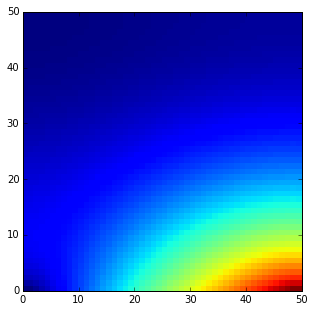

In [25]:
u = calc(dx=0.1, dy = 0.1, n = 50, function = py_update, nSteps = 500)
figure(figsize=(5,5))
pcolor(u)

### Numpy update function

The array slicing in `numpy` allows us to save much time by using automatic looping calculations. For a matrix dimension $n=50$, the speedup compared to pure Python is about 40 times on the first run.

In [27]:
def numpy_update(u, dx2 ,dy2):
    """ Update the u vector at every time step. """
    nx, ny = u.shape
    
    u[1:-1, 1:-1] = ((u[2: , 1:-1] + u[:-2, 1:-1])*dy2 +\
                     (u[1:-1, 2:] + u[1:-1, :-2])*dx2 )/(2*dy2 + 2*dx2)

In [36]:
%time u=calc(dx=0.1, dy=0.1, n=50, function = numpy_update, nSteps=500)

CPU times: user 29.7 ms, sys: 2.62 ms, total: 32.4 ms
Wall time: 31.3 ms


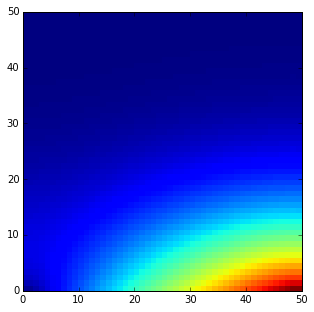

In [29]:
u = calc(dx=0.1, dy = 0.1, n = 50, function = numpy_update, nSteps = 500)
figure(figsize=(5,5))
pcolor(u); 

### Weave update function

The `weave` module allows you to insert fragments of code in C. Even better, it communicates with Scipy or Python variables seamlessly. 

In [7]:
from scipy import weave
from scipy.weave import converters
def inline_update(u, dx2, dy2):        
    """Takes a time step using inlined C code -- this version uses
    blitz arrays."""        
    nx, ny = u.shape
    dnr_inv = 0.5 / (dx2 + dy2)

    code = """
            for (int i=1; i<nx-1; ++i) {
               for (int j=1; j<ny-1; ++j) {
                   u(i,j) = ((u(i-1,j) + u(i+1,j))*dy2 +
                             (u(i,j-1) + u(i,j+1))*dx2)*dnr_inv;
               }
           }
           return_val = 0;
           """
    err = weave.inline(code, ['u', 'dx2', 'dy2', 'dnr_inv', 'nx','ny'],
                       type_converters = converters.blitz)


In [13]:
%time u=calc(dx=0.1, dy=0.1, n=100, function = inline_update, nSteps=500)

CPU times: user 43.3 ms, sys: 1.73 ms, total: 45 ms
Wall time: 44.7 ms


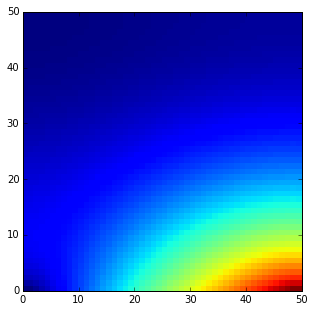

In [21]:
u = calc(dx=0.1, dy = 0.1, n = 50, function = inline_update, nSteps = 500)
figure(figsize=(5,5))
pcolor(u)

In [5]:
from scipy import weave
from scipy.weave import converters


def blitz_update(u, dx2, dy2):        
    """Takes a time step using a numpy expression that has been
    blitzed using weave."""        
    # The actual iteration
    dnr_inv = 0.5/(dx2 + dy2)
    expr = "u[1:-1, 1:-1] = ((u[0:-2, 1:-1] + u[2:, 1:-1])*dy2 + "\
           "(u[1:-1,0:-2] + u[1:-1, 2:])*dx2)*dnr_inv"
    weave.blitz(expr, check_size=0)


In [6]:
%time u=calc(dx=0.1, dy=0.1, n=50, function = blitz_update, nSteps=500)

CPU times: user 48.7 ms, sys: 13.9 ms, total: 62.6 ms
Wall time: 1.85 s


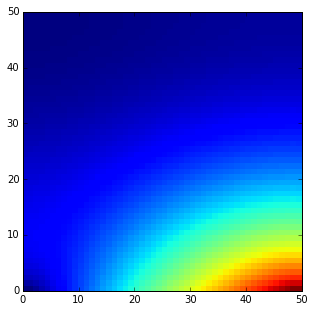

In [22]:
u = calc(dx=0.1, dy = 0.1, n = 50, function = blitz_update, nSteps = 500)
figure(figsize=(5,5))
pcolor(u)

### Numba update function

The `numba` package converts the Python function into compiled C code quickly and efficiently. The only thing I have done is to import the modules and wrap the update function with `autojit` - only three lines. Also, you can call `autojit` with a decorator, instead of calling it with an inline function:

```
@autojit
def f(x):
    return x
```

In [30]:
from numba import double
from numba.decorators import jit, autojit

def numba_calc(dx,dy,n, function, nSteps):
    u = zeros((n,n))
    
    for i in range(nSteps):
        # Update boundary conditions
        u[0,:] = linspace(0,1,n)   # Dirichlet b.c. at the top
        u[n-1,:] = u[n-2,:]        # Neumann b.c. at the bottom
        u[:,0] = u[:,1]            # Neumann b.c. at the left
        u[:,n-1] = u[:,n-2]        # Neumann b.c. at the right
    
        autojit(function(u, dx*dx, dy*dy))
        
    return u

In [51]:
%time u=numba_calc(dx=0.1, dy=0.1, n=50, function = numpy_update, nSteps=500)

CPU times: user 34.4 ms, sys: 2.31 ms, total: 36.7 ms
Wall time: 50.6 ms


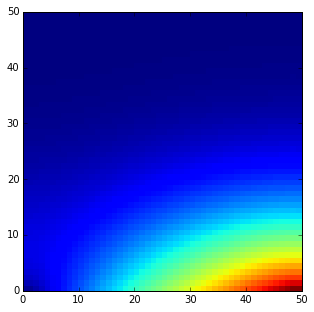

In [33]:
u = numba_calc(dx=0.1, dy = 0.1, n = 50, function = numpy_update, nSteps = 500)
figure(figsize=(5,5))
pcolor(u)

### numpy + numba versus numpy

In [46]:
%time u=numba_calc(dx=0.1, dy=0.1, n=500, function = numpy_update, nSteps=500)

CPU times: user 1.31 s, sys: 20.7 ms, total: 1.34 s
Wall time: 1.34 s


In [45]:
%time u=calc(dx=0.1, dy=0.1, n=500, function = numpy_update, nSteps=500)

CPU times: user 1.36 s, sys: 28.1 ms, total: 1.39 s
Wall time: 1.4 s
